In [51]:
from cmonge.datasets.conditional_loader import ConditionalDataModule
from cmonge.utils import load_config
from cmonge.metrics import wasserstein_distance


import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from tqdm import tqdm


In [2]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}


subset_map = {
    "CD4": default_colors["teal"],
    "CD8": default_colors["purple"],
}

# Embeddings

In [1]:
base_dir = "/path/to/car/embeddings/"
configs_path = "/path/to/model/configs/"
data_path = "/path/to/data/"
variants_path = "/path/to/variants/"
geneset_path = "/path/to/genesets/"

all_embeddings = ["CD4_metadata", "CD8_metadata", "embed_11d", "embed_16d", 
                  "esm2_t33_650M_UR50D_full_dim", "esm2_t33_650M_UR50D_full_seq", "esm2_t33_650M_UR50D_tail_dim", "esm2_t33_650M_UR50D_tail_seq", 
                  "esm2_t36_3B_UR50D_full_dim", "esm2_t36_3B_UR50D_full_seq", "esm2_t36_3B_UR50D_tail_dim", "esm2_t36_3B_UR50D_tail_seq", 
                  "esm2_t48_15B_UR50D_full_dim", "esm2_t48_15B_UR50D_full_seq", "esm2_t48_15B_UR50D_tail_dim", "esm2_t48_15B_UR50D_tail_seq",
                  "esm_small_full_dim", "esm_small_full_seq", "esm_small_tail_dim", "esm_small_tail_seq"
                 ]

# CD4

In [4]:
config_path = f"{configs_path}cmonge/conditional-monge-cars-CD4_esm_small_full_seq.yml"

In [5]:
config = load_config(config_path)
config.data.file_path = f"{data_path}CD4.h5ad"
config.data.features = f"{geneset_path}functional_and_score_genes.txt"
config.data.drugs_path = f"{variants_path}CAR_variants.txt"
config.condition.conditions = [c for c in config.condition.conditions if not c=='NA-NA-NA']

In [6]:
CD4_datamodule = ConditionalDataModule(config.data, config.condition, config.ae)

2024-08-30 16:07:01.074 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for 41BB-41BB-z
2024-08-30 16:07:01.588 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-08-30 16:07:01.901 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2024-08-30 16:07:01.902 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2024-08-30 16:07:01.902 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-08-30 16:07:01.903 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for 41BB-CD28-z
2024-08-30 16:07:02.405 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-08-30 16:07:02.424 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target datase

In [8]:
labels = CD4_datamodule.train_conditions
distance_matrix = jnp.full(
    shape=(len(labels), len(labels)), fill_value=jnp.inf
)

cond_to_loaders = CD4_datamodule.train_dataloaders()
with tqdm(total=len(labels) ** 2) as pbar:
    for i, (cond_i, loader_i) in enumerate(cond_to_loaders.items()):
        for j, (cond_j, loader_j) in enumerate(cond_to_loaders.items()):
            if (
                distance_matrix.at[i, j].get() == jnp.inf
                and distance_matrix.at[j, i].get() == jnp.inf
            ):
                target_batch_i = next(loader_i[1])
                target_batch_j = next(loader_j[1])
                w_dist = wasserstein_distance(
                    target_batch_i, target_batch_j
                )
                distance_matrix = distance_matrix.at[i, j].set(w_dist)
                distance_matrix = distance_matrix.at[j, i].set(w_dist)
            pbar.update(1)

CD4_distance = distance_matrix

2024-08-30 16:07:56.266 | INFO     | cmonge.datasets.conditional_loader:train_dataloaders:161 - Setting up train dataloaders.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 961/961 [00:58<00:00, 16.47it/s]


## CD8

In [9]:
config_path = f"{configs_path}conditional-monge-cars-CD8_esm_small_full_seq.yml"

In [15]:
config = load_config(config_path)
config.data.file_path = f"{data_path}CD8.h5ad"
config.data.features = f"{geneset_path}functional_and_score_genes.txt"
config.data.drugs_path = f"{variants_path}CAR_variants.txt"
config.condition.conditions = [c for c in config.condition.conditions if not c=='NA-NA-NA']

In [16]:
CD8_datamodule = ConditionalDataModule(config.data, config.condition, config.ae)

2024-08-30 16:18:56.466 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for 41BB-41BB-z
2024-08-30 16:18:56.920 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-08-30 16:18:56.942 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2024-08-30 16:18:56.943 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2024-08-30 16:18:56.943 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2024-08-30 16:18:56.944 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:81 - Setting up datamodules for 41BB-CD28-z
2024-08-30 16:18:57.349 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2024-08-30 16:18:57.441 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target datas

In [17]:
labels = CD8_datamodule.train_conditions
distance_matrix = jnp.full(
    shape=(len(labels), len(labels)), fill_value=jnp.inf
)

cond_to_loaders = CD8_datamodule.train_dataloaders()
with tqdm(total=len(labels) ** 2) as pbar:
    for i, (cond_i, loader_i) in enumerate(cond_to_loaders.items()):
        for j, (cond_j, loader_j) in enumerate(cond_to_loaders.items()):
            if (
                distance_matrix.at[i, j].get() == jnp.inf
                and distance_matrix.at[j, i].get() == jnp.inf
            ):
                target_batch_i = next(loader_i[1])
                target_batch_j = next(loader_j[1])
                w_dist = wasserstein_distance(
                    target_batch_i, target_batch_j
                )
                distance_matrix = distance_matrix.at[i, j].set(w_dist)
                distance_matrix = distance_matrix.at[j, i].set(w_dist)
            pbar.update(1)

CD8_distance = distance_matrix

2024-08-30 16:19:10.443 | INFO     | cmonge.datasets.conditional_loader:train_dataloaders:161 - Setting up train dataloaders.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 961/961 [01:26<00:00, 11.08it/s]


# Embeddings and stress

In [45]:
all_CD4_stresses = []
all_CD8_stresses = []
for embedding in all_embeddings:
    print(embedding)
    embed =  pd.read_csv(f"{base_dir}{embedding}", index_col=0).T
    embed = embed.drop("NA-NA-NA", axis=0)
    embed = embed.div(embed.sum(axis=1),axis="rows")

    dis = euclidean_distances(embed)
    CD4_stress = ((dis.ravel() - CD4_distance.ravel()) ** 2).sum() / 2
    all_CD4_stresses.append(CD4_stress)

    CD8_stress = ((dis.ravel() - CD8_distance.ravel()) ** 2).sum() / 2
    all_CD8_stresses.append(CD8_stress)
CD4_res = pd.DataFrame([all_embeddings, all_CD4_stresses], index=["embedding", "stress"]).T
CD4_res["stress"] = CD4_res["stress"].astype(float)
CD4_res = CD4_res.sort_values("stress")
CD4_res["subset"] = "CD4"

CD8_res = pd.DataFrame([all_embeddings, all_CD8_stresses], index=["embedding", "stress"]).T
CD8_res["stress"] = CD8_res["stress"].astype(float)
CD8_res = CD8_res.sort_values("stress")
CD8_res["subset"] = "CD8"

res = pd.concat([CD4_res, CD8_res])

CD4_metadata
CD8_metadata
embed_11d
embed_16d
esm2_t33_650M_UR50D_full_dim
esm2_t33_650M_UR50D_full_seq
esm2_t33_650M_UR50D_tail_dim
esm2_t33_650M_UR50D_tail_seq
esm2_t36_3B_UR50D_full_dim
esm2_t36_3B_UR50D_full_seq
esm2_t36_3B_UR50D_tail_dim
esm2_t36_3B_UR50D_tail_seq
esm2_t48_15B_UR50D_full_dim
esm2_t48_15B_UR50D_full_seq
esm2_t48_15B_UR50D_tail_dim
esm2_t48_15B_UR50D_tail_seq
esm_small_full_dim
esm_small_full_seq
esm_small_tail_dim
esm_small_tail_seq


<Axes: xlabel='stress', ylabel='embedding'>

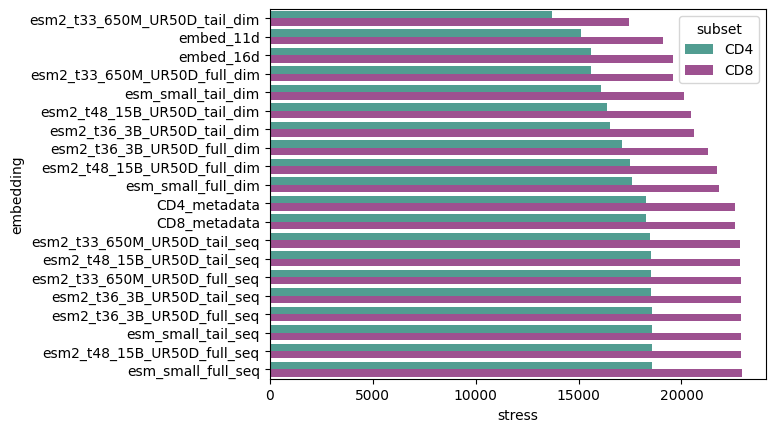

In [46]:
sns.barplot(data=res, y="embedding", x="stress", hue="subset", palette=subset_map)


# PCA of high-dimensional embeddings

In [54]:
all_CD4_stresses = []
all_CD8_stresses = []
for embedding in all_embeddings:
    print(embedding)
    embed =  pd.read_csv(f"{base_dir}{embedding}", index_col=0).T
    embed = embed.drop("NA-NA-NA", axis=0)
    if embed.shape[1]>40:
        pca = PCA(n_components=20)
        embed = pd.DataFrame(pca.fit_transform(embed))
    print(embed.shape)

    dis = euclidean_distances(embed)
    CD4_stress = ((dis.ravel() - CD4_distance.ravel()) ** 2).sum() / 2
    all_CD4_stresses.append(CD4_stress)

    CD8_stress = ((dis.ravel() - CD8_distance.ravel()) ** 2).sum() / 2
    all_CD8_stresses.append(CD8_stress)
CD4_res = pd.DataFrame([all_embeddings, all_CD4_stresses], index=["embedding", "stress"]).T
CD4_res["stress"] = CD4_res["stress"].astype(float)
CD4_res = CD4_res.sort_values("stress")
CD4_res["subset"] = "CD4"

CD8_res = pd.DataFrame([all_embeddings, all_CD8_stresses], index=["embedding", "stress"]).T
CD8_res["stress"] = CD8_res["stress"].astype(float)
CD8_res = CD8_res.sort_values("stress")
CD8_res["subset"] = "CD8"

res = pd.concat([CD4_res, CD8_res])

CD4_metadata
(31, 39)
CD8_metadata
(31, 39)
embed_11d
(31, 11)
embed_16d
(31, 16)
esm2_t33_650M_UR50D_full_dim
(31, 20)
esm2_t33_650M_UR50D_full_seq
(31, 20)
esm2_t33_650M_UR50D_tail_dim
(31, 20)
esm2_t33_650M_UR50D_tail_seq
(31, 20)
esm2_t36_3B_UR50D_full_dim
(31, 20)
esm2_t36_3B_UR50D_full_seq
(31, 20)
esm2_t36_3B_UR50D_tail_dim
(31, 20)
esm2_t36_3B_UR50D_tail_seq
(31, 20)
esm2_t48_15B_UR50D_full_dim
(31, 20)
esm2_t48_15B_UR50D_full_seq
(31, 20)
esm2_t48_15B_UR50D_tail_dim
(31, 20)
esm2_t48_15B_UR50D_tail_seq
(31, 20)
esm_small_full_dim
(31, 20)
esm_small_full_seq
(31, 20)
esm_small_tail_dim
(31, 20)
esm_small_tail_seq
(31, 20)


<Axes: xlabel='stress', ylabel='embedding'>

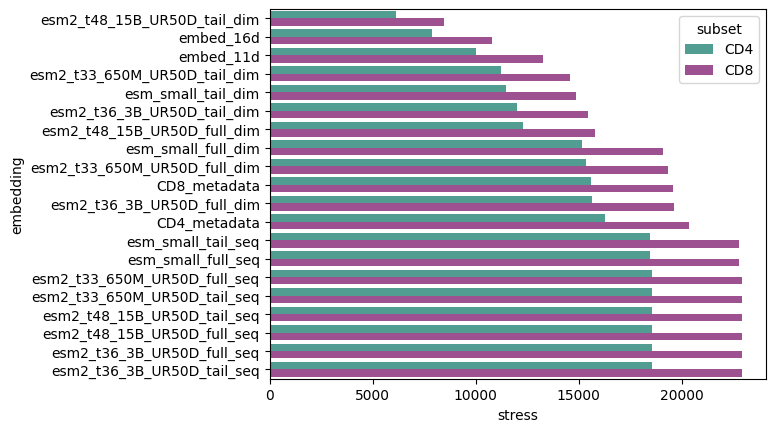

In [56]:
sns.barplot(data=res, y="embedding", x="stress", hue="subset", palette=subset_map)


In [58]:
pd.read_csv(f"{base_dir}esm2_t33_650M_UR50D_tail_dim", index_col=0)

,41BB-41BB-z,41BB-CD28-z,41BB-CD40-z,41BB-CTLA4-z,41BB-IL15RA-z,41BB-NA-z,CD28-41BB-z,CD28-CD28-z,CD28-CD40-z,CD28-CTLA4-z,...,CTLA4-IL15RA-z,CTLA4-NA-z,IL15RA-41BB-z,IL15RA-CD28-z,IL15RA-CD40-z,IL15RA-CTLA4-z,IL15RA-IL15RA-z,IL15RA-NA-z,NA-NA-NA,NA-NA-z
0,0.057292,0.013660,0.050705,0.043572,0.056211,0.031474,0.019424,0.021479,-0.000647,0.001475,...,0.030583,0.012994,0.064844,0.005805,0.048786,0.046733,0.069669,0.025249,-0.033926,0.003810
1,-0.052851,-0.074248,-0.097442,-0.068467,-0.094747,-0.087984,-0.067577,-0.046433,-0.087856,-0.064369,...,-0.087149,-0.078043,-0.077073,-0.082522,-0.106780,-0.072069,-0.053828,-0.095827,-0.062990,-0.092383
2,-0.059810,-0.043260,-0.060083,-0.056004,-0.034855,-0.028619,-0.042021,-0.047404,-0.066186,-0.051081,...,-0.041637,-0.047322,-0.024252,-0.025553,-0.056127,-0.044411,-0.047323,-0.027710,0.075879,-0.029102
3,0.091209,0.060829,0.088548,0.089891,0.100464,0.097770,0.063285,0.036773,0.023107,0.017328,...,0.081334,0.069877,0.103187,0.036918,0.076489,0.083609,0.080346,0.074662,0.074692,0.062663
4,0.035433,0.001853,0.000063,-0.015479,-0.008595,-0.000305,0.006536,0.027911,0.025576,0.019320,...,0.010858,0.016238,-0.001646,0.019722,0.012100,-0.006607,0.058119,0.028599,-0.095566,0.042196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,-0.054232,0.014674,0.023786,0.025174,0.003933,-0.019978,0.018276,-0.034559,0.001598,0.015226,...,-0.000877,0.001693,0.002260,0.003617,0.002501,0.016498,-0.064451,-0.027328,0.073034,-0.034522
1276,-0.016676,-0.021490,-0.011741,-0.018873,-0.039097,-0.043874,-0.019875,-0.006711,0.015033,0.012664,...,-0.018972,-0.015311,-0.032563,-0.019036,-0.013684,-0.022556,-0.021053,-0.028348,-0.009144,-0.019923
1277,-0.033335,-0.014282,0.036067,0.012797,0.010275,-0.023698,-0.001895,-0.086090,0.000341,-0.014400,...,-0.013170,-0.049763,0.006605,-0.037305,0.007155,-0.013813,-0.078116,-0.051882,-0.121432,-0.112891
1278,0.126349,0.086029,0.048045,0.052043,0.068198,0.102729,0.071781,0.146908,0.089522,0.102176,...,0.088780,0.129491,0.047398,0.109863,0.075036,0.071916,0.132962,0.132144,0.100990,0.179680
